<a href="https://colab.research.google.com/github/mxrxdth/mxrxdth001/blob/master/Old_Toronto_v_s_Manhattan_v_s_Paris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents


1. Introduction/Business Problem

2. Data
   


# 1. Introduction/Business Problem

**1.1. Background**

Is New York City more like Toronto or Paris?
 
It would be interesting to compare the neighborhoods of these multicultural cities as the financial capital of different countries and determine how similar or dissimilar they are. However, While the area of Paris is 40.7 mi² with its 20 ‎Arrondissements, in our data New York City is 302.6 mi² with 302 neighborhoods and Toronto 243.3 mi² with 98 neighborhoods. Old Toronto(https://en.wikipedia.org/wiki/Toronto) and Manhattan (22.82 mi²) as the most densely populated part of the respective city, should be more comparable.


**1.2. Problem**

Therefore, our problem is refined as: Is Manhattan more like core Toronto or Paris? To be specific, which neighborhoods in Toronto and Paris would have a similar setting or vibe to Manhattan?


**1.3. Interest**

If a NYC-based brand would like to expand its business to the overseas, especially the brick-and-mortar, whether they should expect similarity or dissimilarity in its options of cities? Further, if Toronto and Paris are taken into consideration, people are likely to be also interested in which neighborhoods are better choices.



# 2. Data

**Data Acquisition and Cleaning**

**2.1. Data sources**

The sources of city neighborhoods, their respective latitude and longitude are as follows.

Toronto: http://cocl.us/Geospatial_data, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

New York City: https://cocl.us/new_york_dataset

Paris: http://download.geonames.org/export/zip/FR.zip, processed and stored in https://docs.google.com/spreadsheets/d/e/2PACX-1vQXNcKhCQi7jy0AoRKKAafKRqZsLJhwC8jfgBrdHLOqFiPo09A8IHb6C-GpNWI21g/pub?output=xlsx
 
Based on the geo coordinates of neighborhoods in the three cities, I obtain the data of venues around each neighborhood via Foursquare API.
 
The old Toronto data (the borough name of a neighborhood contains “Toronto”) is filtered out from Toronto data; Manhattan data (the borough name of a neighborhood is “Manhattan”) out of New York City data; The Paris data is cleaned out of the geonames dataset of France.

 
**2.2. Data cleaning**

To estimate the radius in Foursquare, apply: (City Area/ Number of Neighborhoods / 𝛑)^(½) * 1609.34 meters/mile - the result would be 500 for Manhattan, 600 for Old Toronto, 800 for Paris. 

There are overlaps of radii, i.e. some venues are included in more than one neighborhood, so two types of dummy datasets are derived.
When analyzing based down on neighborhoods, directly get the venue category dummies from venues data around the neighborhoods.

When analyzing based on city level, remove duplicates: depends on subsets ‘Venue + Venue Latitude + Venue Longitude’. (‘Venue Latitude + Venue Longitude’ insufficient. There are possibilities that different venues are at the same coordinates so add ‘Venue’; In case one venue is recorded for more than one category in the database, 'Venue Category' is added to retain the complete category info.)

Going further, the venue category frequencies (as percentages of group sum) - venues are grouped by city, then neighborhood.

In [289]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge --no-deps altair --yes
!conda install -c conda-forge --no-deps vincent --yes

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge geopy=1.19.0 --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge --no-deps folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
Libraries imported.


In [290]:
!pip install branca
import folium
print('folium imported!')

folium imported!


## 1) Old Toronto

In [291]:
 # The webpage URL whose table we want to extract 
url_toronto_codes = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
  
# Assign the table data to a Pandas dataframe 
df_toronto = pd.read_html(url_toronto_codes)
df_toronto = df_toronto[0]
df_toronto.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [292]:
df_toronto.isnull().sum()

Postal code      0
Borough          0
Neighborhood    77
dtype: int64

In [293]:
df_toronto = df_toronto[df_toronto['Borough'] != 'Not assigned'].reset_index(drop=True)
df_toronto.rename(columns={"Postal code": "Postal Code"}, inplace=True)
df_toronto.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [294]:
df_toronto.isnull().sum()

Postal Code     0
Borough         0
Neighborhood    0
dtype: int64

In [295]:
df_toronto_grouped = df_toronto.groupby('Postal Code').agg({'Borough':'first', 'Neighborhood':'sum'}).reset_index()
df_toronto_grouped = df_toronto_grouped.apply(lambda x: x.str.replace(' /',','))
print(df_toronto_grouped.shape)
df_toronto_grouped.head()

(103, 3)


,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [296]:
url_toronto = "http://cocl.us/Geospatial_data"
df_toronto_coordinates = pd.read_csv(url_toronto)
df_toronto_coordinates

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [297]:
df_toronto_grouped.columns[0]==df_toronto_coordinates.columns[0]

True

In [298]:
toronto_data = df_toronto_grouped.join(df_toronto_coordinates.set_index('Postal Code'), on='Postal Code')
toronto_data.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [299]:
print('There are {} neighborhoods in Toronto.'.format(len(toronto_data['Neighborhood'].unique())))

There are 98 neighborhoods in Toronto.


In [300]:
#
old_toronto_data = toronto_data[toronto_data['Borough'].str.contains('Toronto')].reset_index(drop=True)
old_toronto_data

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


### Foursquare

In [301]:
CLIENT_ID = 'CLDHWKFPZ03KEUOBPFAL2O3YCRHPJ0MOSJLPJXFBIY4EHVAI' # your Foursquare ID
CLIENT_SECRET = '3EYLGLVIXUOV2WIIA5M3CAROIPGFZZKV1QO3QUQQSUHLNNIT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CLDHWKFPZ03KEUOBPFAL2O3YCRHPJ0MOSJLPJXFBIY4EHVAI
CLIENT_SECRET:3EYLGLVIXUOV2WIIA5M3CAROIPGFZZKV1QO3QUQQSUHLNNIT


### Create a function to repeat the same process to all the neighborhoods in the cities

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [303]:
old_toronto_venues = getNearbyVenues(names=old_toronto_data['Neighborhood'],
                                   latitudes=old_toronto_data['Latitude'],
                                   longitudes=old_toronto_data['Longitude'],
                                    radius=600
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst  Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction South
Parkdale, Ro

In [304]:
print(old_toronto_venues.shape)
old_toronto_venues.head()

(2130, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,Tori's Bakeshop,43.672114,-79.290331,Vegetarian / Vegan Restaurant
2,The Beaches,43.676357,-79.293031,Beaches Bake Shop,43.680363,-79.289692,Bakery
3,The Beaches,43.676357,-79.293031,The Beech Tree,43.680493,-79.288846,Gastropub
4,The Beaches,43.676357,-79.293031,Ed's Real Scoop,43.672630,-79.287993,Ice Cream Shop


In [305]:
old_toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,91,91,91,91,91,91
"Brockton, Parkdale Village, Exhibition Place",43,43,43,43,43,43
Business reply mail Processing CentrE,26,26,26,26,26,26
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",19,19,19,19,19,19
Central Bay Street,100,100,100,100,100,100
Christie,18,18,18,18,18,18
Church and Wellesley,100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,44,44,44,44,44,44


In [306]:
print('There are {} uniques categories.'.format(len(old_toronto_venues['Venue Category'].unique())))

There are 251 uniques categories.


In [307]:
print('There are {} neighborhoods in Old Toronto.'.format(len(old_toronto_venues['Neighborhood'].unique())))

There are 39 neighborhoods in Old Toronto.


In [308]:
# one hot encoding
old_toronto_onehot = pd.get_dummies(old_toronto_venues['Venue Category'], ).drop('Neighborhood', axis=1)
old_toronto_onehot.head()

,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [309]:
# add neighborhood column back to dataframe
old_toronto_onehot.insert(0, 'Neighborhood', old_toronto_venues['Neighborhood'], True)
old_toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [310]:
'Neiborhood'in (old_toronto_venues['Venue Category'].unique())

False

## 2) Manhattan

In [311]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [0]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [0]:
neighborhoods_data = newyork_data['features']

In [314]:
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

In [0]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [316]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [0]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [318]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [319]:
print('There are {} neighborhoods in New York City.'.format(len(neighborhoods['Neighborhood'].unique())))

There are 302 neighborhoods in New York City.


In [320]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [321]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                   radius=500
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [322]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3154, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [323]:
len((manhattan_venues['Venue Latitude'].astype(str) + ',' + manhattan_venues['Venue Longitude'].astype(str)).unique())

2929

In [324]:
len((manhattan_venues['Venue'].astype(str) + ', ' + manhattan_venues['Venue Latitude'].astype(str)  + ', ' + manhattan_venues['Venue Longitude'].astype(str)).unique())


2929

In [325]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,69,69,69,69,69,69
Carnegie Hill,88,88,88,88,88,88
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,38,38,38,38,38,38
East Village,100,100,100,100,100,100


In [326]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 323 uniques categories.


In [327]:
print('There are {} neighborhoods in Manhattan.'.format(len(manhattan_venues['Neighborhood'].unique())))

There are 40 neighborhoods in Manhattan.


In [328]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + (manhattan_onehot.columns[:-1]).to_list()
manhattan_onehot = manhattan_onehot[fixed_columns]

print(manhattan_onehot.shape)
manhattan_onehot.head()

(3154, 324)


,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American

In [329]:
manhattan_grouped = manhattan_onehot.groupby(['Neighborhood']).mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American

In [0]:
venue_categories_corr = manhattan_grouped.corr()[['Frozen Yogurt Shop']]

In [331]:
corr_with_froyoshop = venue_categories_corr[venue_categories_corr['Frozen Yogurt Shop'].map(abs)>0.65]
corr_with_froyoshop

,Frozen Yogurt Shop
Bistro,0.829185
Empanada Restaurant,0.953820
Frozen Yogurt Shop,1.000000
History Museum,0.953820
Intersection,0.953820
Lounge,0.793552
Restaurant,0.722949
Veterinarian,0.953820


In [332]:
df = manhattan_grouped[['Neighborhood'] + (corr_with_froyoshop.index).to_list()]
df.set_index('Neighborhood', inplace=True)
df

,Bistro,Empanada Restaurant,Frozen Yogurt Shop,History Museum,Intersection,Lounge,Restaurant,Veterinarian
Neighborhood,,,,,,,,
Battery Park City,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Carnegie Hill,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000
Central Harlem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Chelsea,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Chinatown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Civic Center,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
Clinton,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000,0.000000
East Harlem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000
East Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [333]:
for column in df.columns:
  df[column] = df['Frozen Yogurt Shop']/df[column]
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Bistro,Empanada Restaurant,Frozen Yogurt Shop,History Museum,Intersection,Lounge,Restaurant,Veterinarian
Neighborhood,,,,,,,,
Battery Park City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Carnegie Hill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Central Harlem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chelsea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chinatown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Civic Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Clinton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
East Harlem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
East Village,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3) Paris

In [334]:
filedlurl = r'https://docs.google.com/spreadsheets/d/e/2PACX-1vQXNcKhCQi7jy0AoRKKAafKRqZsLJhwC8jfgBrdHLOqFiPo09A8IHb6C-GpNWI21g/pub?output=xlsx'
paris_data = pd.read_excel(filedlurl, sheet_name='paris by arrondissement')
paris_data

,Postal Code,Arrondissement,Latitude,Longitude
0,75001,Paris 01,48.8592,2.3417
1,75002,Paris 02,48.8655,2.3426
2,75003,Paris 03,48.8637,2.3615
3,75004,Paris 04,48.8601,2.3507
4,75005,Paris 05,48.8448,2.3471
5,75006,Paris 06,48.8493,2.3300
6,75007,Paris 07,48.8565,2.3210
7,75008,Paris 08,48.8763,2.3183
8,75009,Paris 09,48.8718,2.3399
9,75010,Paris 10,48.8709,2.3561


In [335]:
paris_venues = getNearbyVenues(names=paris_data['Arrondissement'],
                                   latitudes=paris_data['Latitude'],
                                   longitudes=paris_data['Longitude'],
                                   radius=800
                                  )

Paris 01
Paris 02
Paris 03
Paris 04
Paris 05
Paris 06
Paris 07
Paris 08
Paris 09
Paris 10
Paris 11
Paris 12
Paris 13
Paris 14
Paris 15
Paris 16
Paris 17
Paris 18
Paris 19
Paris 20


In [336]:
print(paris_venues.shape)
paris_venues.head()

(1972, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris 01,48.8592,2.3417,Place du Louvre,48.859841,2.340822,Plaza
1,Paris 01,48.8592,2.3417,Église Saint-Germain-l'Auxerrois (Église Saint...,48.859520,2.341306,Church
2,Paris 01,48.8592,2.3417,Coffee Crêpes,48.858841,2.340802,Coffee Shop
3,Paris 01,48.8592,2.3417,Le Fumoir,48.860424,2.340868,Cocktail Bar
4,Paris 01,48.8592,2.3417,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza


In [337]:
paris_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Paris 01,100,100,100,100,100,100
Paris 02,100,100,100,100,100,100
Paris 03,100,100,100,100,100,100
Paris 04,100,100,100,100,100,100
Paris 05,100,100,100,100,100,100
Paris 06,100,100,100,100,100,100
Paris 07,88,88,88,88,88,88
Paris 08,100,100,100,100,100,100
Paris 09,100,100,100,100,100,100


In [338]:
print('There are {} uniques categories in Paris.'.format(len(paris_venues['Venue Category'].unique())))

There are 209 uniques categories in Paris.


In [339]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + (paris_onehot.columns[:-1].to_list())
paris_onehot = paris_onehot[fixed_columns]

print(paris_onehot.shape)
paris_onehot.head()

(1972, 210)


,Neighborhood,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basque Restaurant,Beer Bar,Beer Garden,Beer Store,Bistro,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Canal,Candy Store,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Resort,Restaurant,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Savoyard Restaurant,Scenic Lookout,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Soccer Stadium,Soup Place,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Track Stadium,Trail,Train Station,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Women's Store
0,Paris 01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Paris 01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Paris 01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

## 4) Cities

In [0]:
manhattan_venues.insert(0, 'City', 'Manhattan')
paris_venues.insert(0, 'City', 'Paris')
old_toronto_venues.insert(0, 'City', 'Old Toronto')

In [341]:
venues_concat = pd.concat([manhattan_venues, paris_venues, old_toronto_venues], 
                         axis = 0, ignore_index=True)
print(venues_concat.shape)

(7256, 8)


In [342]:
venues_concat_unique = venues_concat.drop_duplicates(subset=['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
print(venues_concat_unique.shape)
venues_concat_unique.head()

(6272, 8)


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Manhattan,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Manhattan,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Manhattan,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Manhattan,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [343]:
# one hot encoding
venues_concat_unique_onehot = pd.get_dummies(venues_concat_unique[['Venue Category']], prefix="", prefix_sep="").drop('Neighborhood', axis=1)

# add neighborhood and city column back to dataframe
venues_concat_unique_onehot.insert(0, 'Neighborhood', venues_concat_unique['Neighborhood'],False)
venues_concat_unique_onehot.insert(0, 'City', venues_concat_unique['City'], False)

print(venues_concat_unique_onehot.shape)
venues_concat_unique_onehot.head()

(6272, 399)


,City,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Sup

In [344]:
freq_by_city = venues_concat_unique_onehot.groupby('City').mean()
print(freq_by_city.shape)
freq_by_city

(3, 397)


,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,P

In [0]:
from scipy.stats import ks_2samp

freq_manhattan = freq_by_city.values[0]
freq_old_toronto = freq_by_city.values[1]
freq_paris = freq_by_city.values[2]

In [346]:
ks_2samp(freq_manhattan, freq_old_toronto)

Ks_2sampResult(statistic=0.18387909319899245, pvalue=2.789835017685976e-06)

In [347]:
ks_2samp(freq_manhattan, freq_paris)

Ks_2sampResult(statistic=0.2871536523929471, pvalue=7.956491394226413e-15)

In [348]:
# one hot encoding
venues_concat_onehot = pd.get_dummies(venues_concat[['Venue Category']], prefix="", prefix_sep="").drop('Neighborhood', axis=1)

# add neighborhood and city column back to dataframe
venues_concat_onehot.insert(0, 'Neighborhood', venues_concat['Neighborhood'],False)
venues_concat_onehot.insert(0, 'City', venues_concat['City'], False)

print(venues_concat_onehot.shape)
venues_concat_onehot.head()

(7256, 399)


,City,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Sup

In [0]:
venue_counts = venues_concat.groupby(['City','Neighborhood'])['Venue'].count().to_frame()
venue_category_counts = venues_concat.groupby(['City','Neighborhood'])['Venue Category'].nunique().to_frame()
venue_and_category_counts = venue_counts.join(venue_category_counts).reset_index()

In [350]:
from sklearn import preprocessing

le_city = preprocessing.LabelEncoder()
le_city.fit(['Manhattan','Old Toronto','Paris'])
city_labels = le_city.transform(venue_and_category_counts['City'].values)
venue_and_category_counts['City Labels'] = city_labels

venue_and_category_counts

,City,Neighborhood,Venue,Venue Category,City Labels
0,Manhattan,Battery Park City,69,43,0
1,Manhattan,Carnegie Hill,88,53,0
2,Manhattan,Central Harlem,45,37,0
3,Manhattan,Chelsea,100,67,0
4,Manhattan,Chinatown,100,57,0
5,Manhattan,Civic Center,100,63,0
6,Manhattan,Clinton,100,62,0
7,Manhattan,East Harlem,38,27,0
8,Manhattan,East Village,100,58,0
9,Manhattan,Financial District,100,55,0


In [0]:
X = venue_and_category_counts.values

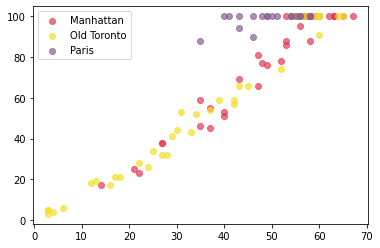

In [352]:
from matplotlib import pyplot as plt

scatter_x = X[:, 3]
scatter_y = X[:, 2]
group = X[:, 0]
color = X[:, 4]
cdict = {'Manhattan': '#E63A54', 'Old Toronto': '#F3E02A', 'Paris': '#8A6094'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, alpha=0.7)
ax.legend()
plt.show()

In [353]:
#venues grouped by neighborhood
venues_grouped = venues_concat_onehot.groupby(['City','Neighborhood']).mean().reset_index()
venues_grouped.head()

,City,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Sup

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [355]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Boat or Ferry,Shopping Mall,Gourmet Shop,Mexican Restaurant,Plaza
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Italian Restaurant,Gym,Gym / Fitness Center,Bookstore,Japanese Restaurant,Pizza Place,Cosmetics Shop
2,Central Harlem,Bar,French Restaurant,Art Gallery,American Restaurant,Seafood Restaurant,Chinese Restaurant,African Restaurant,Gym / Fitness Center,Market,Fried Chicken Joint
3,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Bakery,Italian Restaurant,Ice Cream Shop,Cocktail Bar,Seafood Restaurant,Pizza Place,Pet Store
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Bakery,Spa,Hotpot Restaurant,Salon / Barbershop,Optical Shop,Dessert Shop,Vietnamese Restaurant


In [356]:
# set number of clusters
kclusters = 3

venues_grouped_clustering = venues_grouped.drop(['City','Neighborhood'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [357]:
# add clustering labels
venues_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
print(venues_grouped.shape)
venues_grouped.head()

(99, 400)


,Cluster Labels,City,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Pap

In [358]:
coordinates_neighborhood = pd.concat([manhattan_data[['Neighborhood', 'Latitude', 'Longitude']].sort_values(by='Neighborhood'),
           old_toronto_data[['Neighborhood', 'Latitude', 'Longitude']].sort_values(by='Neighborhood'),
           paris_data[['Arrondissement', 'Latitude', 'Longitude']].rename(columns={"Arrondissement": "Neighborhood"}).sort_values(by='Neighborhood')])
print(coordinates_neighborhood.shape)
coordinates_neighborhood.head()

(99, 3)


,Neighborhood,Latitude,Longitude
28,Battery Park City,40.711932,-74.016869
30,Carnegie Hill,40.782683,-73.953256
6,Central Harlem,40.815976,-73.943211
17,Chelsea,40.744035,-74.003116
1,Chinatown,40.715618,-73.994279


In [359]:
cities_neighborhoods_clustered_coordinates = venues_grouped[['Cluster Labels', 'City', 'Neighborhood']].join(coordinates_neighborhood.set_index('Neighborhood'), on='Neighborhood')
cities_neighborhoods_clustered_coordinates.head()

,Cluster Labels,City,Neighborhood,Latitude,Longitude
0,1,Manhattan,Battery Park City,40.711932,-74.016869
1,1,Manhattan,Carnegie Hill,40.782683,-73.953256
2,1,Manhattan,Central Harlem,40.815976,-73.943211
3,1,Manhattan,Chelsea,40.744035,-74.003116
4,1,Manhattan,Chinatown,40.715618,-73.994279


In [360]:
# merge clustered neighborhood with most common venues for each neighborhood
cities_neighborhoods_clustered = cities_neighborhoods_clustered_coordinates.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood').sort_values(by=['Cluster Labels', 'City']).reset_index(drop=True)
cities_neighborhoods_clustered # check the last columns!

,Cluster Labels,City,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Old Toronto,Forest Hill North & West,43.696948,-79.411307,Jewelry Store,Sushi Restaurant,Trail,Park,Farmers Market,Duty-free Shop,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant
1,0,Old Toronto,Lawrence Park,43.728020,-79.388790,Park,Swim School,Bus Line,Electronics Store,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner
2,0,Old Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,Park,Gym,Playground,Yoga Studio,Eastern European Restaurant,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,0,Old Toronto,Rosedale,43.679563,-79.377529,Park,Trail,Playground,Eastern European Restaurant,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,1,Manhattan,Battery Park City,40.711932,-74.016869,Park,Hotel,Gym,Coffee Shop,Memorial Site,Boat or Ferry,Shopping Mall,Gourmet Shop,Mexican Restaurant,Plaza
5,1,Manhattan,Carnegie Hill,40.782683,-73.953256,Coffee Shop,Café,Yoga Studio,Italian Restaurant,Gym,Gym / Fitness Center,Bookstore,Japanese Restaurant,Pizza Place,Cosmetics Shop
6,1,Manhattan,Central Harlem,40.815976,-73.943211,Bar,French Restaurant,Art Gallery,American Restaurant,Seafood Restaurant,Chinese Restaurant,African Restaurant,Gym / Fitness Center,Market,Fried Chicken Joint
7,1,Manhattan,Chelsea,40.744035,-74.003116,Coffee Shop,Art Gallery,American Restaurant,Bakery,Italian Restaurant,Ice Cream Shop,Cocktail Bar,Seafood Restaurant,Pizza Place,Pet Store
8,1,Manhattan,Chinatown,40.715618,-73.994279,Chinese Restaurant,Cocktail Bar,American Restaurant,Bakery,Spa,Hotpot Restaurant,Salon / Barbershop,Optical Shop,Dessert Shop,Vietnamese Restaurant
9,1,Manhattan,Civic Center,40.715229,-74.005415,Coffee Shop,French Restaurant,Cocktail Bar,Hotel,Yoga Studio,Gym / Fitness Center,Spa,Café,American Restaurant,Sushi Restaurant


In [361]:
cities_neighborhoods_clustered.groupby(['Cluster Labels'])['City'].value_counts()

Cluster Labels  City       
0               Old Toronto     4
1               Manhattan      40
                Old Toronto    35
2               Paris          20
Name: City, dtype: int64

In [362]:
cluster_neighborhood_counts = cities_neighborhoods_clustered.groupby(['Cluster Labels'])['City'].value_counts().to_frame().rename(columns={'City':'Neighborhood Counts'}).reset_index()
cluster_neighborhood_counts

,Cluster Labels,City,Neighborhood Counts
0,0,Old Toronto,4
1,1,Manhattan,40
2,1,Old Toronto,35
3,2,Paris,20


In [363]:
cluster_neighborhood_counts = pd.pivot_table(cluster_neighborhood_counts, values='Neighborhood Counts', index=['Cluster Labels'],
                    columns=['City'], fill_value=0)
cluster_neighborhood_counts

City,Manhattan,Old Toronto,Paris
Cluster Labels,,,
0,0,4,0
1,40,35,0
2,0,0,20


In [364]:
cluster_neighborhood_counts.columns.name = ''
cluster_neighborhood_counts

,Manhattan,Old Toronto,Paris
Cluster Labels,,,
0,0,4,0
1,40,35,0
2,0,0,20


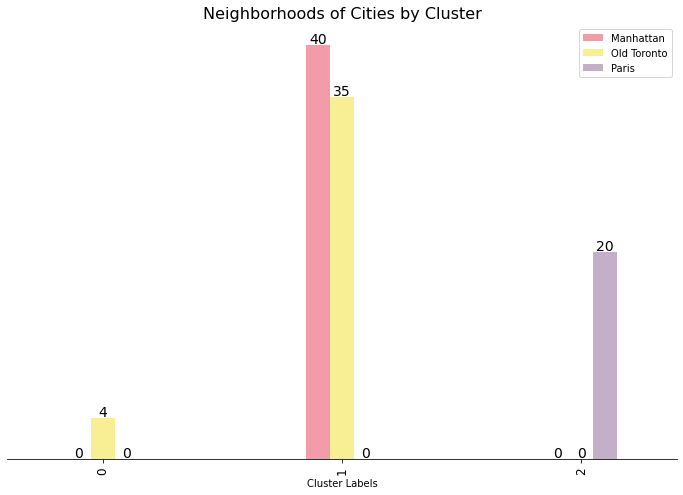

In [365]:
bar_width = 0.3
ax = cluster_neighborhood_counts.plot(kind='bar', figsize=(12, 8), width=bar_width, color=['#E63A54', '#F3E02A', '#8A6094'],
                     alpha=0.5, fontsize=12)

ax.set_title('Neighborhoods of Cities by Cluster', fontsize=16)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_yaxis().set_visible(False)

for n in range(cluster_neighborhood_counts.shape[-1]):
    for index, value in enumerate(cluster_neighborhood_counts.iloc[:,n].values):
        ax.text(index+(n-1)*bar_width/(cluster_neighborhood_counts.shape[-1]),value+0.2, value,ha='center',fontsize=14)

In [0]:
cluster_venues_grouped = venues_grouped.groupby('Cluster Labels').mean().reset_index()

In [367]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
clusters_venues_sorted = pd.DataFrame(columns=columns)
clusters_venues_sorted['Cluster Labels'] = cluster_venues_grouped['Cluster Labels']

for ind in np.arange(cluster_venues_grouped.shape[0]):
    clusters_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_venues_grouped.iloc[ind, :], num_top_venues)

clusters_venues_sorted.head()

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Park,Trail,Playground,Swim School,Bus Line,Jewelry Store,Sushi Restaurant,Gym,Eastern European Restaurant,Dog Run
1,1,Coffee Shop,Café,Italian Restaurant,Park,Pizza Place,Bakery,Bar,Gym,Sandwich Place,American Restaurant
2,2,French Restaurant,Hotel,Bar,Italian Restaurant,Bakery,Plaza,Wine Bar,Japanese Restaurant,Café,Bistro


In [393]:
clusters_venues_sorted.set_index('Cluster Labels').transpose()

Cluster Labels,0,1,2
1st Most Common Venue,Park,Coffee Shop,French Restaurant
2nd Most Common Venue,Trail,Café,Hotel
3rd Most Common Venue,Playground,Italian Restaurant,Bar
4th Most Common Venue,Swim School,Park,Italian Restaurant
5th Most Common Venue,Bus Line,Pizza Place,Bakery
6th Most Common Venue,Jewelry Store,Bakery,Plaza
7th Most Common Venue,Sushi Restaurant,Bar,Wine Bar
8th Most Common Venue,Gym,Gym,Japanese Restaurant
9th Most Common Venue,Eastern European Restaurant,Sandwich Place,Café
10th Most Common Venue,Dog Run,American Restaurant,Bistro


In [369]:
# set number of clusters
kclusters_1 = 5

venues_grouped_clustering_1 = venues_grouped.drop(['City','Neighborhood'], 1)

# run k-means clustering
kmeans_1 = KMeans(n_clusters=kclusters_1, random_state=2).fit(venues_grouped_clustering_1)

# check cluster labels generated for each row in the dataframe
kmeans_1.labels_

array([0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 0,
       4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4,
       4, 0, 4, 4, 4, 0, 0, 4, 2, 4, 4, 4, 0, 4, 3, 4, 2, 4, 4, 4, 4, 4,
       2, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [370]:
# add clustering labels
venues_grouped_1 = venues_grouped

venues_grouped_1.drop('Cluster Labels', axis=1, inplace=True)
venues_grouped_1.insert(0, 'Cluster Labels', kmeans_1.labels_)
print(venues_grouped_1.shape)
venues_grouped_1.head()

(99, 400)


,Cluster Labels,City,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Basque Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Pap

In [371]:
cities_neighborhoods_clustered_coordinates_1 = venues_grouped_1[['Cluster Labels', 'City', 'Neighborhood']].join(coordinates_neighborhood.set_index('Neighborhood'), on='Neighborhood')
cities_neighborhoods_clustered_coordinates_1.head()

,Cluster Labels,City,Neighborhood,Latitude,Longitude
0,0,Manhattan,Battery Park City,40.711932,-74.016869
1,4,Manhattan,Carnegie Hill,40.782683,-73.953256
2,4,Manhattan,Central Harlem,40.815976,-73.943211
3,4,Manhattan,Chelsea,40.744035,-74.003116
4,4,Manhattan,Chinatown,40.715618,-73.994279


In [372]:
# merge clustered neighborhood with most common venues for each neighborhood
cities_neighborhoods_clustered_1 = cities_neighborhoods_clustered_coordinates_1.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood').sort_values(by=['Cluster Labels', 'City']).reset_index(drop=True)
cities_neighborhoods_clustered_1 # check the last columns!

,Cluster Labels,City,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Manhattan,Battery Park City,40.711932,-74.016869,Park,Hotel,Gym,Coffee Shop,Memorial Site,Boat or Ferry,Shopping Mall,Gourmet Shop,Mexican Restaurant,Plaza
1,0,Manhattan,East Harlem,40.792249,-73.944182,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Deli / Bodega,Street Art,Gas Station,Sandwich Place,Steakhouse,Park
2,0,Manhattan,Hamilton Heights,40.823604,-73.949688,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,School,Caribbean Restaurant,Sandwich Place,Chinese Restaurant
3,0,Manhattan,Inwood,40.867684,-73.921210,Mexican Restaurant,Restaurant,Café,Pizza Place,Lounge,Chinese Restaurant,Park,American Restaurant,Bakery,Wine Bar
4,0,Manhattan,Manhattanville,40.816934,-73.957385,Coffee Shop,Deli / Bodega,Seafood Restaurant,Chinese Restaurant,Italian Restaurant,Mexican Restaurant,Park,Food & Drink Shop,Sushi Restaurant,Juice Bar
5,0,Manhattan,Morningside Heights,40.808000,-73.963896,Park,Coffee Shop,American Restaurant,Bookstore,Deli / Bodega,Burger Joint,Ice Cream Shop,New American Restaurant,Salad Place,Sandwich Place
6,0,Manhattan,Roosevelt Island,40.762160,-73.949168,Park,Japanese Restaurant,Dry Cleaner,Supermarket,Soccer Field,Dog Run,Liquor Store,Outdoors & Recreation,Deli / Bodega,School
7,0,Manhattan,Stuyvesant Town,40.731000,-73.974052,Bar,Park,Boat or Ferry,Farmers Market,Pet Service,Harbor / Marina,Fountain,Cocktail Bar,Heliport,Coffee Shop
8,0,Manhattan,Tudor City,40.746917,-73.971219,Café,Park,Mexican Restaurant,Diner,Greek Restaurant,Deli / Bodega,Thai Restaurant,Restaurant,Asian Restaurant,Pizza Place
9,0,Manhattan,Washington Heights,40.851903,-73.936900,Café,Bakery,Grocery Store,Mobile Phone Shop,Chinese Restaurant,Spanish Restaurant,Cosmetics Shop,Mexican Restaurant,Tapas Restaurant,Park


In [373]:
cities_neighborhoods_clustered_1.groupby(['Cluster Labels'])['City'].value_counts()

Cluster Labels  City       
0               Manhattan      10
                Old Toronto     8
1               Paris          20
2               Old Toronto     3
3               Old Toronto     1
4               Manhattan      30
                Old Toronto    27
Name: City, dtype: int64

In [374]:
cluster_neighborhood_counts_1 = cities_neighborhoods_clustered_1.groupby(['Cluster Labels'])['City'].value_counts().to_frame().rename(columns={'City':'Neighborhood Counts'}).reset_index()
cluster_neighborhood_counts_1

,Cluster Labels,City,Neighborhood Counts
0,0,Manhattan,10
1,0,Old Toronto,8
2,1,Paris,20
3,2,Old Toronto,3
4,3,Old Toronto,1
5,4,Manhattan,30
6,4,Old Toronto,27


In [375]:
cluster_neighborhood_counts_1 = pd.pivot_table(cluster_neighborhood_counts_1, values='Neighborhood Counts', index=['Cluster Labels'],
                    columns=['City'], fill_value=0)
cluster_neighborhood_counts_1.columns.name = ''
cluster_neighborhood_counts_1['5-Cluster'] = cluster_neighborhood_counts_1.sum(axis=1)
cluster_neighborhood_counts_1

,Manhattan,Old Toronto,Paris,5-Cluster
Cluster Labels,,,,
0,10,8,0,18
1,0,0,20,20
2,0,3,0,3
3,0,1,0,1
4,30,27,0,57


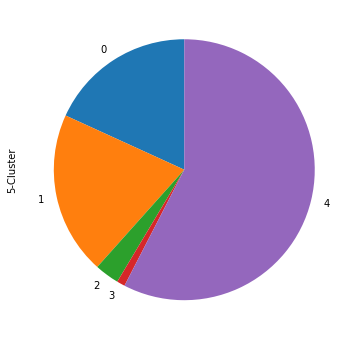

In [376]:
cluster_neighborhood_counts_1.plot(kind='pie', y = '5-Cluster', figsize=(8,6),
 startangle=90, shadow=False, labels=cluster_neighborhood_counts_1.index, legend = False, fontsize=10)

In [377]:
from sklearn import metrics
metrics.silhouette_score(venues_grouped_clustering, kmeans.labels_, metric='euclidean')

0.16364854458293498

In [378]:
metrics.silhouette_score(venues_grouped_clustering_1, kmeans_1.labels_, metric='euclidean')

0.2637524141987047

In [0]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt

In [0]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(venues_grouped_clustering) 
    kmeanModel.fit(venues_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(venues_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / venues_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(venues_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / venues_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_

In [381]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.17680701523949205
2 : 0.16577700788326566
3 : 0.15237389501424245
4 : 0.14798685730324054
5 : 0.14592867322316133
6 : 0.1379216060859076
7 : 0.13610851235318197
8 : 0.1316634921661502
9 : 0.12753213615933728


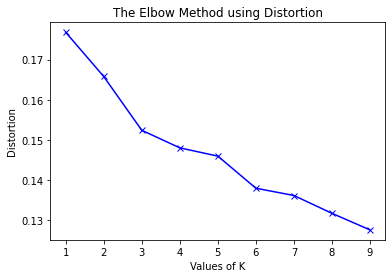

In [382]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

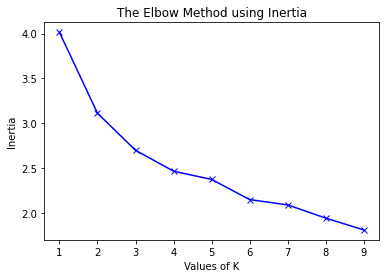

In [383]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [384]:
# create map
latitude=40
longitude=-40
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4.4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_neighborhoods_clustered['Latitude'], cities_neighborhoods_clustered['Longitude'], 
                                  cities_neighborhoods_clustered['Neighborhood'], cities_neighborhoods_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [385]:
# create map
map_clusters = folium.Map(location=[cities_neighborhoods_clustered_coordinates.groupby('City').mean().loc['Manhattan', 'Latitude'], 
                                    cities_neighborhoods_clustered_coordinates.groupby('City').mean().loc['Manhattan', 'Longitude']], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_neighborhoods_clustered['Latitude'], cities_neighborhoods_clustered['Longitude'], 
                                  cities_neighborhoods_clustered['Neighborhood'], cities_neighborhoods_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [386]:
# create map
map_clusters = folium.Map(location=[cities_neighborhoods_clustered_coordinates.groupby('City').mean().loc['Old Toronto', 'Latitude'], 
                                    cities_neighborhoods_clustered_coordinates.groupby('City').mean().loc['Old Toronto', 'Longitude']], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_neighborhoods_clustered['Latitude'], cities_neighborhoods_clustered['Longitude'], 
                                  cities_neighborhoods_clustered['Neighborhood'], cities_neighborhoods_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [387]:
# create map
map_clusters = folium.Map(location=[cities_neighborhoods_clustered_coordinates.groupby('City').mean().loc['Paris', 'Latitude'], 
                                    cities_neighborhoods_clustered_coordinates.groupby('City').mean().loc['Paris', 'Longitude']], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_neighborhoods_clustered['Latitude'], cities_neighborhoods_clustered['Longitude'], 
                                  cities_neighborhoods_clustered['Neighborhood'], cities_neighborhoods_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [388]:
# the score is based on the venue counts in each city and the respective frequency in Manhattan.
score_city = venues_concat_onehot.groupby('City').sum().dot(freq_by_city.transpose()['Manhattan'])
score_city

City
Manhattan      41.094572
Old Toronto    28.260498
Paris          23.205872
dtype: float64

In [389]:
list = [len(manhattan_venues['Neighborhood'].unique()), len(old_toronto_venues['Neighborhood'].unique()), len(paris_venues['Neighborhood'].unique())]
neighborhood_counts_city = pd.Series(list, index=score_city.index)
neighborhood_counts_city

City
Manhattan      40
Old Toronto    39
Paris          20
dtype: int64

In [390]:
mean_score_city_per_neighborhood = score_city.divide(neighborhood_counts_city, fill_value=0)
mean_score_city_per_neighborhood

City
Manhattan      1.027364
Old Toronto    0.724628
Paris          1.160294
dtype: float64

In [391]:
score_neighborhood = (venues_concat_onehot[venues_concat_onehot.City.isin(['Paris', 'Old Toronto'])].groupby(['City', 'Neighborhood']).sum().dot(freq_by_city.transpose()['Manhattan'])).to_frame()
score_neighborhood.rename(columns={0:'Score'}, inplace=True)    
score_neighborhood.head()                                                                                                       

Score
City        Neighborhood                                                
Old Toronto Berczy Park                                         1.124957
            Brockton, Parkdale Village, Exhibition Place        0.482417
            Business reply mail Processing CentrE               0.202800
            CN Tower, King and Spadina, Railway Lands, Harb...  0.126323
            Central Bay Street                                  1.753499

In [392]:
#Assume that lower Absolute Difference with the average Manhattan neighorhood score suggests higher similarity.
score_neighborhood_sorted = score_neighborhood.assign(AD_with_Manhattan = abs(score_neighborhood['Score'] - mean_score_city_per_neighborhood.values[0])).sort_values('AD_with_Manhattan').drop('Score', axis=1).reset_index()
score_neighborhood_sorted = score_neighborhood_sorted.join(cities_neighborhoods_clustered.drop(['City', 'Latitude', 'Longitude'], axis=1).set_index('Neighborhood'), on='Neighborhood')
score_neighborhood_sorted.index = score_neighborhood_sorted.index + 1

top10_similar_neiborhoood = score_neighborhood_sorted.head(10)
top10_similar_neiborhoood

,City,Neighborhood,AD_with_Manhattan,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Paris,Paris 07,0.005070,2,French Restaurant,Hotel,Plaza,Garden,Café,Italian Restaurant,History Museum,Historic Site,Restaurant,Tailor Shop
2,Paris,Paris 06,0.014971,2,French Restaurant,Hotel,Italian Restaurant,Wine Bar,Plaza,Ice Cream Shop,Pastry Shop,Garden,Chocolate Shop,Bookstore
3,Paris,Paris 12,0.026238,2,Hotel,French Restaurant,Bistro,Supermarket,Bar,Italian Restaurant,Bakery,Pizza Place,Chinese Restaurant,Garden
4,Paris,Paris 01,0.038290,2,French Restaurant,Plaza,Hotel,Historic Site,Art Museum,Ice Cream Shop,Restaurant,Bakery,Italian Restaurant,Theater
5,Old Toronto,"Kensington Market, Chinatown, Grange Park",0.039211,1,Bar,Café,Vegetarian / Vegan Restaurant,Dessert Shop,Chinese Restaurant,Mexican Restaurant,Coffee Shop,Yoga Studio,Record Shop,Pizza Place
6,Paris,Paris 19,0.050137,2,French Restaurant,Bar,Café,Restaurant,Italian Restaurant,Supermarket,Japanese Restaurant,Pool,Brasserie,Metro Station
7,Old Toronto,"Queen's Park, Ontario Provincial Government",0.050580,1,Coffee Shop,Burger Joint,Sandwich Place,Park,Italian Restaurant,Gastropub,Burrito Place,Falafel Restaurant,Café,Diner
8,Paris,Paris 11,0.079840,2,French Restaurant,Bar,Italian Restaurant,Cocktail Bar,Bistro,Restaurant,Pizza Place,Café,Wine Bar,Moroccan Restaurant
9,Paris,Paris 04,0.086668,2,French Restaurant,Bakery,Ice Cream Shop,Café,Art Gallery,Coffee Shop,Plaza,Gourmet Shop,Hotel,Restaurant
10,Paris,Paris 02,0.090082,2,French Restaurant,Wine Bar,Cocktail Bar,Hotel,Pedestrian Plaza,Plaza,Coffee Shop,Japanese Restaurant,Bakery,Cheese Shop
